# Libraries

1. [py_midicsv](https://github.com/timwedde/py_midicsv): Used for reading MIDI files as CSV and vice versa.

2. [mido](https://github.com/mido/mido): Utilized for calculating tempo, tick, signature, and seconds in MIDI files.

3. [configparser](https://github.com/jaraco/configparser): Essential for reading and saving INI files.

4. [pickle](https://docs.python.org/pt-br/3/library/pickle.html): Employed for reading and saving PyTorch datasets.

5. [librosa](https://librosa.org/doc/main/index.html): A Python package for music and audio analysis.

6. [pydub](https://github.com/jiaaro/pydub): Used for audio processing tasks such as reading, manipulating, and saving audio files.



# Recreating MIDI files

In [99]:
from py_midicsv import midi_to_csv, csv_to_midi, FileWriter
from os import path, scandir, listdir
from configparser import ConfigParser
from mido import tick2second, second2tick
import numpy as np
from numpy import array, split, sum, zeros, arange, isin, concatenate
from pickle import dump, load
from torch.utils.data import Dataset, DataLoader
from typing import List
from torch.nn import Module, Sequential, Conv2d, Flatten, MaxPool2d, ReLU, Linear, MSELoss
from torch import device, cuda, optim, tensor, float32
from matplotlib.pyplot import subplots, show, figure, title
from matplotlib.colors import ListedColormap, BoundaryNorm
from pydub import AudioSegment
import librosa

class MidiHeroFile:
    """
    This class reads MIDI files and recreates them with a normalized tempo.

    Attributes:
        path_folder (str): The path of the folder that contains the song's information, such as notes.mid and song.ini.
        save_recreated (bool): Whether you want to save the .mid file or not. Default value is False. Obs: this will override your midi file.
        save_backup (bool): Whether you want to save the .mid backup file or not. Default value is False.
    """
    def __init__(self, path_folder, save_recreated=False, save_backup=False):
        self.path_folder = path_folder
        self.save_backup = save_backup
        self.save_recreated = save_recreated

        self.preview_start_time = self.__get_preview_start_time__()

        self.full_song_ogg_data = self.__get_full_song_ogg_data__()
        
        self.midi_data = midi_to_csv(path.join(path_folder, "notes.mid"))

        header = self.midi_data[0].replace('\n', '').split(', ')
        self.type = int(header[3])
        self.num_channels = int(header[4])
        self.signature = int(header[5])
        self.__recreate_midi_file__()
        
    


    def __get_preview_start_time__(self):
        """
        Retrieve the preview start time from the 'song.ini' configuration file.

        Returns:
            int: The preview start time in seconds.
        
        Note:
            If the 'song.ini' file is not found or if there's an error parsing the file,
            the function returns 0 as the default preview start time.
        """
        try:
            config = ConfigParser()
            config.read(path.join(self.path_folder, "song.ini"))
            return int(config.get('song', 'preview_start_time', fallback='0'))
        except Exception as e:
            print(f"Error while retrieving preview start time: {e}")
            return 0


    def save(self, data, filename):
        """
        Convert and save CSV data as a MIDI file.

        Args:
            data (List[List[int]]): The CSV data representing MIDI events.
            filename (str): The name of the MIDI file to be saved.

        Note:
            The CSV data should be in the format expected by the 'csv_to_midi' function.
            The resulting MIDI file will be saved in the specified 'filename' within
            the configured 'path_folder'.
        """
        midi_object = csv_to_midi(data)
        with open(path.join(self.path_folder, filename), "wb") as output_file:
            midi_writer = FileWriter(output_file)
            midi_writer.write(midi_object)
    

    def __recalculate_seconds__(self, index, array):
        """
        Recalculate the time in seconds for MIDI events starting from the given index.

        Args:
            index (int): The index in the array where recalculation should start.
            array (List[List[str]]): The array containing MIDI event data.

        Returns:
            List[List[str]]: The modified array with recalculated time in seconds.

        Note:
            This method assumes that the array structure follows the expected format
            for MIDI event data, and it recalculates the time in seconds based on the
            tempo information and the time positions in ticks.

        Args:
            index (int): The index from which to start recalculating seconds.
            array (List[List[str]]): The MIDI event array.

        Returns:
            List[List[str]]: The modified MIDI event array with updated time in seconds.
        """
        tempo = int(array[index][3].strip())
        position = int(array[index][1].strip())
        seconds = array[index][-1]
        for i in range(index + 1, len(array)):
            current_position = int(array[i][1].strip())
            array[i][-1] = tick2second(current_position - position, 480, tempo) + seconds
        return array


    def __recreate_midi_file__(self):
        """
    Recreate and save a modified MIDI file based on the provided MIDI event data.

    Note:
        If 'save_backup' is enabled, a backup of the original MIDI file is saved
        as 'notes_backup.mid'. The method filters and sorts relevant MIDI events,
        recalculates time in seconds, and generates a new MIDI file named 'notes.mid'.
        The modified MIDI data is stored in the 'midi_data' attribute.

    Raises:
        Exception: If an error occurs during the process.

    """
        try:
            # Save a backup of the original MIDI file
            if self.save_backup:
                self.save(self.midi_data, "notes_backup.mid")

            # Filter and sort relevant MIDI events
            filtered = filter(lambda x: "Tempo" in x or "Note_on_c" in x, self.midi_data)
            data = list(map(lambda x: x.replace('\n', '').split(', ') + [0], filtered))
            sorted_data = sorted(data, key=lambda x: (int(x[1]), int(x[0])))

            # Recalculate time in seconds for Tempo events
            for i in range(len(sorted_data)):
                if sorted_data[i][2] == "Tempo":
                    sorted_data = self.__recalculate_seconds__(i, sorted_data)

            # Initial tempo value for the recreated MIDI file
            first_tempo = 624595

            # Initial part of the MIDI file structure
            to_save = [
                f'0, 0, Header, {self.type}, {self.num_channels}, {self.signature}\n',
                '1, 0, Start_track\n',
                '1, 0, Title_t, "midi_export"\n',
                '1, 0, Time_signature, 4, 2, 24, 8\n',
                f'1, 0, Tempo, {first_tempo}\n',
                '1, 0, End_track\n',
                '2, 0, Start_track\n',
                '2, 0, Title_t, "EVENTS"\n',
                '2, 0, End_track\n',
                '3, 0, Start_track\n',
                '3, 0, Title_t, "PART GUITAR"\n',
            ]

            # Iterate through sorted data and update time in ticks
            for row in sorted_data:
                if row[2] == "Tempo":
                    continue
                tick = second2tick(row[-1], self.signature, first_tempo)
                r = row[:-1]
                r[1] = str(tick)

                to_save.append(', '.join(r) + "\n")

            # Determine the last tick value
            last_tick = to_save[-1].split(', ')[1]

            # Final part of the MIDI file structure
            to_save.append(f'3, {last_tick}, End_track\n')
            to_save.append('0, 0, End_of_file\n')

            # Update the 'midi_data' attribute with the modified MIDI data
            self.midi_data = to_save

            # Save the recreated MIDI file
            if self.save_recreated:
                self.save(to_save, "notes.mid")

        except Exception as e:
            # Raise an exception if an error occurs during the process
            raise Exception(f"Error during MIDI file recreation: {e}")
    
    def __get_notes_filter_by_difficulty__(self, difficulty):
        """
        Get the note ranges corresponding to the specified difficulty level.

        Args:
            difficulty (int): The difficulty level for which to retrieve note ranges.
                Should be an integer between 0 and the maximum difficulty level.

        Returns:
            range: The note range associated with the specified difficulty level.

        Raises:
            ValueError: If the provided difficulty level is outside the valid range.

        """
        difficulties = [
            range(60, 65),
            range(72, 77),
            range(84, 89),
            range(96, 101),
        ]

        # Check if the provided difficulty level is within the valid range
        if 0 <= difficulty < len(difficulties):
            return difficulties[difficulty]
        else:
            # Raise an exception for an invalid difficulty level
            raise ValueError("Invalid difficulty level. Please provide a valid difficulty level.")


    def get_song_size(self):
        """
        Get the size of the song based on the last Note_on_c event in ticks.

        Returns:
            int: The size of the song in ticks.

        Note:
            The method filters the MIDI data to include only 'Note_on_c' events and
            calculates the size of the song based on the timing information in ticks.

        Example:
            To get the size of the song:
            ```
            path_folder = "/path/to/song"
            instance = MidiHeroFile(path_folder)
            song_size = instance.get_song_size()
            ```

        """
        try:
            # Filter MIDI data to include only 'Note_on_c' events
            filtered_track = list(filter(lambda x: "Note_on_c" in x, self.midi_data))

            # Get the last tick value from the filtered track
            last_tick = int(filtered_track[-1].split(', ')[1])

            # Calculate the size of the song considering a fixed resolution of 768 ticks
            return last_tick + (768 - (last_tick % 768))

        except Exception as e:
            # Handle any potential errors and provide an informative message
            raise Exception(f"Error in calculating song size: {e}")

            

    def get_notes_by_time(self, difficulty):
        """
        Retrieve notes data based on the specified difficulty level.

        Args:
            difficulty (int): The difficulty level for which to retrieve notes data.
                Should be an integer between 0 and 4.

        Returns:
            numpy.ndarray:
                A 2D array representing the notes data, where each row corresponds to a different color,
                and columns represent time ticks. The array has a shape of (5, 768 * total_seconds),
                with values of 0 or 1. A value of 0 indicates that no note is played at that specific tick,
                while a value of 1 indicates that a note is played.

        Raises:
            ValueError: If the provided difficulty level is outside the valid range.

        Example:
            To get notes data for difficulty level 2:
            ```
            path_folder = "/path/to/song"
            instance = MidiHeroFile(path_folder)
            notes_data = instance.get_notes_by_time(2)
            ```

        """
        try:
            # Convert MIDI data to a numpy array with relevant columns
            filtered_track = np.array([list(map(int, x.replace('\n', '').split(', ')[:2] + x.replace('\n', '').split(', ')[3:]))
                                    for x in self.midi_data if "Note_on_c" in x])

            # Get the last tick value from the filtered track
            last_tick = filtered_track[-1, 1]

            # Calculate the size of the song considering a fixed resolution of 768 ticks
            song_size = last_tick + (768 - (last_tick % 768))

            # Create an array representing the entire song timeline
            song_empty = np.arange(song_size)

            # Get notes filter based on difficulty level
            notes_filter = np.array(list(self.__get_notes_filter_by_difficulty__(difficulty)))

            # Filter notes based on the selected difficulty
            filtered_notes = filtered_track[np.isin(filtered_track[:, -2], notes_filter), :]

            # Initialize the final data array with zeros
            final_data = np.zeros((5, len(song_empty)), dtype=int)

            # Iterate through different colors and update the final data array
            for color in range(5):
                color_filter = notes_filter[color]

                # Mask for 'Note_on_c' events corresponding to key presses
                key_down_mask = (filtered_notes[:, -2] == color_filter) & (filtered_notes[:, -1] == 100)

                # Mask for 'Note_on_c' events corresponding to key releases
                key_up_mask = (filtered_notes[:, -2] == color_filter) & (filtered_notes[:, -1] == 0)

                # Extract key down and key up times
                key_down_times = filtered_notes[key_down_mask, 1].astype(int)
                key_up_times = filtered_notes[key_up_mask, 1].astype(int)

                # Update the final data array with ones during key press intervals
                for down_time, up_time in zip(key_down_times, key_up_times):
                    final_data[color, down_time:up_time] = 1

            return final_data

        except Exception as e:
            # Handle any potential errors and provide an informative message
            raise ValueError(f"Error in retrieving notes data: {e}")


    def __get_full_song_ogg_data__(self):
        """
        Retrieve the audio data from all non-preview OGG files in the song folder.

        Returns:
            numpy.ndarray:
                A 1D array containing the audio data of the combined OGG files. The data is represented
                as floating-point values ranging from -1.0 to 1.0, normalized from the original
                16-bit signed integer samples.

        Note:
            This method reads all non-preview OGG files in the song folder, overlays them to create a
            mixed audio track, and then converts the audio data to a numpy array of floating-point values.

        """
        try:
            # List all files in the song folder
            all_files = listdir(self.path_folder)

            # Filter OGG files (excluding those with 'preview' in the filename)
            ogg_files = [file for file in all_files
                        if file.endswith(".ogg") and 'preview' not in file]

            mixed_audio, sr = librosa.load(path.join(self.path_folder, ogg_files[0]), sr=44100)
            for file in ogg_files[1:]:
                s, sr  = librosa.load(path.join(self.path_folder, file), sr=44100)
                mixed_audio += s

            return mixed_audio

        except Exception as e:
            # Handle any potential errors and provide an informative message
            raise Exception(f"Error in retrieving full song OGG data: {e}")

        
    def get_melspectrogram(self):
        """
        Generate a mel spectrogram from the full song's audio data.

        Returns:
            numpy.ndarray:
                A 2D array representing the mel spectrogram of the audio. The values are in decibels (log scale)
                and are normalized based on the maximum power.

        Note:
            This method uses librosa to compute the mel spectrogram from the full song's audio data.

        """
        try:
            # Compute mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=self.full_song_ogg_data, sr=44100)
            
            # Convert to decibels (log scale) and normalize
            normalized_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

            return normalized_mel_spectrogram

        except Exception as e:
            # Handle any potential errors and provide an informative message
            raise Exception(f"Error in generating mel spectrogram: {e}")



    def get_mfcc(self, n_mfcc=13):
        """
        Generate Mel-frequency cepstral coefficients (MFCCs) from the full song's audio data.

        Args:
            n_mfcc (int, optional): Number of MFCCs to compute. Defaults to 13.

        Returns:
            numpy.ndarray:
                A 2D array representing the MFCCs of the audio. Each row corresponds to an MFCC feature,
                and each column represents a time frame.

        Note:
            This method uses librosa to compute MFCCs from the full song's audio data.

        """
        try:
            # Compute MFCCs
            mfcc = librosa.feature.mfcc(y=self.full_song_ogg_data, sr=44100, n_mfcc=n_mfcc)

            return mfcc

        except Exception as e:
            # Handle any potential errors and provide an informative message
            raise Exception(f"Error in generating MFCCs: {e}")

    def override_difficulty_notes(self, notes_by_time, difficulty):
        """
        Override the notes in a specified difficulty level and save the modified MIDI file.

        Args:
            notes_by_time (numpy.ndarray): 2D array representing the notes data.
            difficulty (int): Difficulty level for which the notes will be overridden.

        Note:
            This method takes the notes data for a specific difficulty level and modifies the corresponding MIDI file
            by updating the note events. It then saves the modified MIDI file.

        """
        try:
            notes_ids = list(self.__get_notes_filter_by_difficulty__(difficulty))
            first_tempo = 624595

            to_save = [
                f'0, 0, Header, {self.type}, {self.num_channels}, {self.signature}\n',
                '1, 0, Start_track\n',
                '1, 0, Title_t, "midi_export"\n',
                '1, 0, Time_signature, 4, 2, 24, 8\n',
                f'1, 0, Tempo, {first_tempo}\n',
                '1, 0, End_track\n',
                '2, 0, Start_track\n',
                '2, 0, Title_t, "EVENTS"\n',
                '2, 0, End_track\n',
                '3, 0, Start_track\n',
                '3, 0, Title_t, "PART GUITAR"\n',
            ]

            pressing = True
            for time, notes in enumerate(notes_by_time):
                for note_id, note in enumerate(notes):
                    if note == 0:
                        continue

                    velocity = "100" if pressing else "0"
                    line = f"3, {time}, Note_on_c, 0, {notes_ids[note_id]}, {velocity}\n"
                    to_save.append(line)
                    pressing = not pressing

            last_tick = to_save[-1].split(', ')[1]
            to_save.append(f'3, {last_tick}, End_track\n')
            to_save.append('0, 0, End_of_file\n')

            self.save(to_save, 'notes.mid')

        except Exception as e:
            # Handle any potential errors and provide an informative message
            raise Exception(f"Error in overriding difficulty notes: {e}")
    
    def display_song(self, difficulty=0, start=0, end=-1, figsize=(30, 3)):
        """
        Display a visual representation of the song's notes for a specified difficulty and time range.

        Args:
            difficulty (int, optional): Difficulty level of the notes. Defaults to 0.
            start (int, optional): Start time in seconds. Defaults to 0.
            end (int, optional): End time in seconds. If set to -1, displays notes until the end of the song. Defaults to -1.
            figsize (tuple, optional): Figure size for the plot. Defaults to (30, 3).

        Note:
            This method uses Matplotlib to create a visual representation of the song's notes based on the specified difficulty
            and time range.

        """
        try:
            factor = 768

            if end == -1:
                notes = self.get_notes_by_time(difficulty=difficulty)[:, factor * start :]
            else:
                assert start < end, "START should be greater than END"
                notes = self.get_notes_by_time(difficulty=difficulty)[:, factor * start : factor * end]

            for color in range(1, 6):
                notes[color - 1] *= color

            fig, ax = subplots(figsize=figsize)
            
            # Define colormap and boundaries
            cmap = ListedColormap(['white', 'green', 'red', 'yellow', 'blue', 'orange'])
            boundaries = list(range(0, 7))
            norm = BoundaryNorm(boundaries, cmap.N, clip=True)

            # Plot the image with color based on the defined colormap
            ax.imshow(notes, cmap=cmap, norm=norm, interpolation='nearest', aspect='auto', extent=[0, len(notes[0]), 0, len(notes)])

            # Show the plot
            show()

        except Exception as e:
            # Handle any potential errors and provide an informative message
            raise Exception(f"Error in displaying song: {e}")

    def display_melspectrogram(self, figsize=(30, 3)):
        """
        Display the Mel Spectrogram of the full song.

        Args:
            figsize (tuple): Size of the figure in inches (width, height).

        """
        try:
            # Create a figure with the specified size
            figure(figsize=figsize)

            # Display the Mel Spectrogram using librosa's specshow function
            librosa.display.specshow(self.get_melspectrogram(), x_axis='time', y_axis='mel', sr=44100)

            # Add a title to the plot
            title('Mel Spectrogram')

            # Show the plot
            show()

        except Exception as e:
            # Handle any potential errors and provide an informative message
            raise Exception(f"Error in displaying Mel Spectrogram: {e}")


    def display_mfcc(self, n_mfcc=13, figsize=(30, 3)):
        """
        Display the Mel-Frequency Cepstral Coefficients (MFCCs) of the full song.

        Args:
            n_mfcc (int): Number of MFCCs to compute.
            figsize (tuple): Size of the figure in inches (width, height).

        """
        try:
            # Create a figure with the specified size
            figure(figsize=figsize)

            # Display the MFCCs using librosa's specshow function
            librosa.display.specshow(self.get_mfcc(n_mfcc=n_mfcc), x_axis='time', cmap='viridis', sr=44100)

            # Add a title to the plot
            title('MFCCs')

            # Show the plot
            show()

        except Exception as e:
            # Handle any potential errors and provide an informative message
            raise Exception(f"Error in displaying MFCCs: {e}")



        



        

# Creating dataset

In [92]:
class MIDIHeroDataset(Dataset):
    def __init__(self, name, midi_files: List[MidiHeroFile], from_difficuty=0, to_difficuty=3):
        print(f"Generating {name} dataset with {len(midi_files)} songs...")
        sizes_full = [data.get_song_size() // 768 for data in midi_files]
        features_full = [data.get_notes_by_time(from_difficuty) for data in midi_files]
        label_full = [data.get_notes_by_time(to_difficuty) for data in midi_files]
        self.__size = int(sum(sizes_full))
        self.data = []
        self.name = name
        self.__unsqueeze_items__(features_full, label_full, sizes_full)
        print("Done!")

    def __unsqueeze_items__(self, features_full, label_full, sizes_full):
        for size_id, size in enumerate(sizes_full):
            features = split(features_full[size_id], indices_or_sections=size, axis=1)
            labels = split(label_full[size_id], indices_or_sections=size, axis=1)
            for s in range(size):
                self.data.append((features[s], labels[s]))

    def __len__(self):
        return self.__size
    
    def __getitem__(self, index):
        return self.data[index]
    
    def __str__(self):
        return f"Dataset: {self.name}\nNumber of Samples: {self.__len__()}"
    


In [93]:
clone_hero_songs_folder = 'Songs'

song_folders = [f.path for f in scandir(clone_hero_songs_folder) if f.is_dir()]

midi_files = [MidiHeroFile(song_folder) for song_folder in song_folders]

dataset_size = len(midi_files)
train_size = int(len(midi_files) * 0.7)
test_size = int((dataset_size - train_size) * 0.6)
valid_size = dataset_size - train_size - test_size

print(f'''
dataset_size = {dataset_size}
train_size   = {train_size}
test_size    = {test_size}
valid_size   = {valid_size}
''')

train_dataset = MIDIHeroDataset("train", midi_files[:train_size])
test_dataset = MIDIHeroDataset("test", midi_files[train_size: train_size + test_size])
valid_dataset = MIDIHeroDataset("valid", midi_files[train_size + test_size:])


dataset_size = 30
train_size   = 21
test_size    = 5
valid_size   = 4

Generating train dataset with 21 songs...
Done!
Generating test dataset with 5 songs...
Done!
Generating valid dataset with 4 songs...
Done!


In [96]:
feature, label, = train_dataset.__getitem__(32)
print(feature.shape)
print(label.shape)


(5, 768)
(5, 768)


# Saving and Loading Dataset

In [ ]:
please_save = False
please_load = False

In [ ]:
if please_save:
    with open('train_dataset.pkl', 'wb') as file:
        dump(train_dataset, file)

    with open('test_dataset.pkl', 'wb') as file:
        dump(test_dataset, file)

    with open('valid_dataset.pkl', 'wb') as file:
        dump(valid_dataset, file)

In [ ]:
if please_load:
    with open('train_dataset.pkl', 'rb') as file:
        train_dataset:MIDIHeroDataset = load(file)
        print(train_dataset)

    with open('test_dataset.pkl', 'rb') as file:
        test_dataset:MIDIHeroDataset = load(file)
        print(test_dataset)

    with open('valid_dataset.pkl', 'rb') as file:
        test_dataset:MIDIHeroDataset = load(file)
        print(test_dataset)

# Creating DataLoader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

# Displaying song

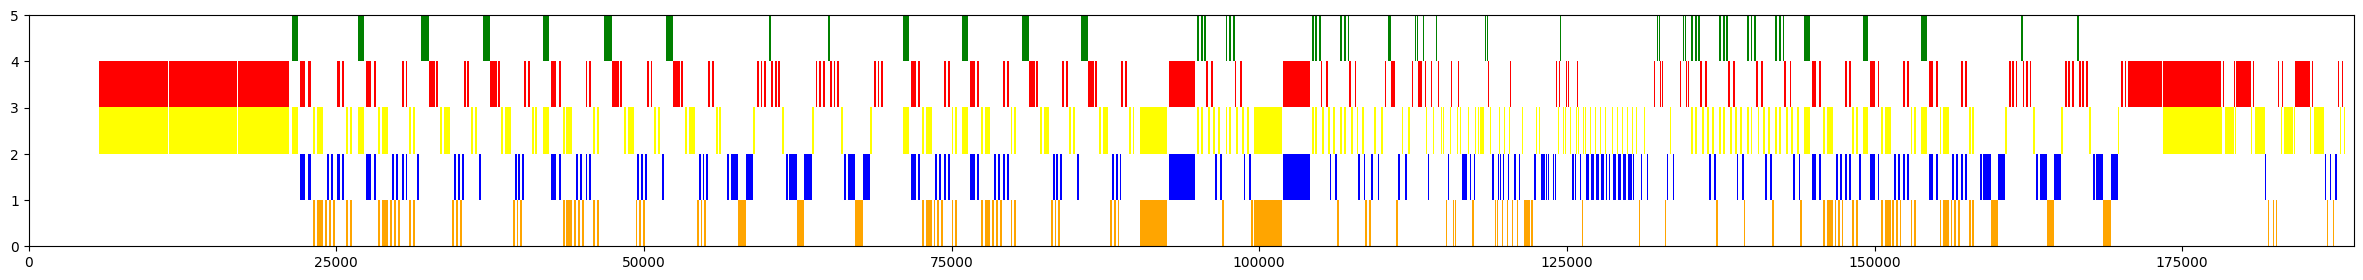

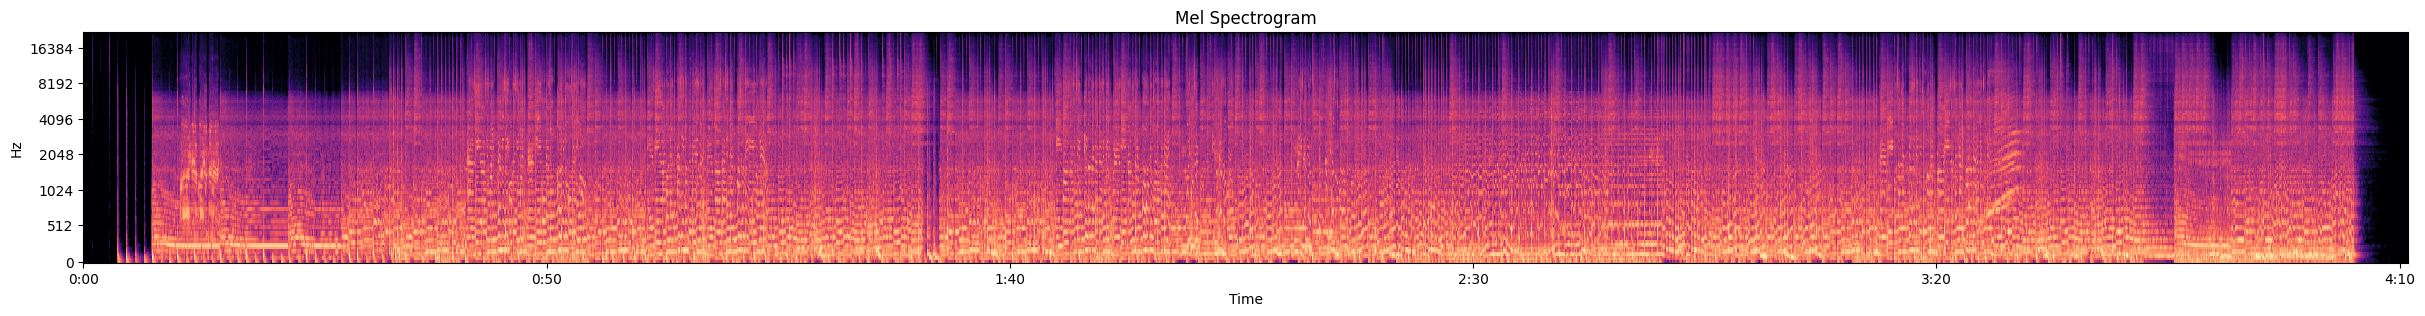

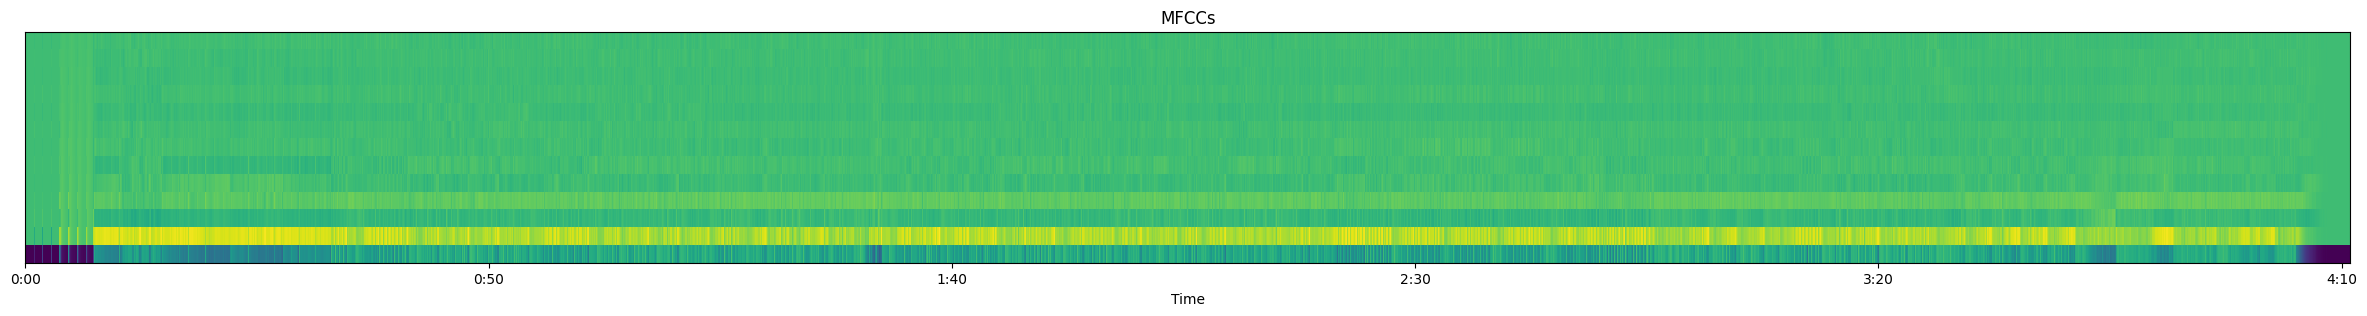

In [100]:

song_folder = '.\Songs\Black Sabbath - Iron Man'

mid = MidiHeroFile(song_folder)
mid.display_song(difficulty=3)
mid.display_melspectrogram()
mid.display_mfcc(n_mfcc=13)